### Mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocessing

In [2]:
FLDR='drive/MyDrive/Processed_COVID_X/'

In [3]:
import os
import cv2

In [4]:
fldrs=os.listdir(FLDR)

In [5]:
fldrs

['Processed_file',
 'Details_1.csv',
 'Processed_file_2',
 'Details_2.csv',
 'model_plot.png']

In [6]:
meta=['Details_1.csv','Details_2.csv']
folders=['Processed_file',"Processed_file_2"]

In [7]:
Images=[]
labels=[]

In [8]:
INDEX=0
fldr=FLDR+folders[INDEX]
meta_file=FLDR+meta[INDEX]
import pandas as pd
df_1=pd.read_csv(meta_file)

In [9]:
df_1["Labels"].value_counts()

0    1521
1     593
Name: Labels, dtype: int64

In [10]:
df_1["File"]='Processed_file'

In [11]:
df_1.head()

Files  Labels            File
0  CR.1.2.840.113564.1722810170.20200313090023421...       0  Processed_file
1  CR.1.2.840.113564.1722810170.20200313100318375...       0  Processed_file
2  CR.1.2.840.113564.1722810170.20200317090830828...       0  Processed_file
3  CR.1.2.840.113564.1722810170.20200317104341875...       0  Processed_file
4  CR.1.2.840.113564.1722810170.20200318082923328...       1  Processed_file

In [12]:
INDEX=1
fldr=FLDR+folders[INDEX]
meta_file=FLDR+meta[INDEX]
import pandas as pd
df_2=pd.read_csv(meta_file)

In [13]:
df_2["File"]='Processed_file_2'

In [14]:
df_2.head()

Files  Labels              File
0   COVID-00001.jpg       1  Processed_file_2
1   COVID-00002.jpg       0  Processed_file_2
2  COVID-00003a.jpg       0  Processed_file_2
3  COVID-00003b.jpg       0  Processed_file_2
4   COVID-00004.jpg       1  Processed_file_2

In [15]:
df_2["Labels"].value_counts()

0    10236
1     3646
Name: Labels, dtype: int64

In [16]:
df_temp_2=df_2[df_2["Labels"]==0]
df_temp_2=df_temp_2[:7263]
df_2_mod=pd.concat([df_temp_2,df_2]).drop_duplicates(keep=False)

In [17]:
df_2_mod["Labels"].value_counts()

1    3646
0    2973
Name: Labels, dtype: int64

In [18]:
df_final=pd.concat([df_1,df_2_mod])

In [19]:
df_final["Labels"].value_counts()

0    4494
1    4239
Name: Labels, dtype: int64

### Processing data

In [20]:
Images=[]
Labels=[]

In [42]:
import cv2

In [22]:
for i in range(len(df_final)):
  if i%100==0:
    print(i)
  try:
    image=cv2.imread(FLDR+df_final.iloc[i]['File']+'/'+df_final.iloc[i]['Files'],cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    Images.append(cv2.resize(image,(256,256)))
    Labels.append(df_final.iloc[i]['Labels'])
  except:
    pass



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700


In [23]:
import numpy as np


In [24]:
Images_n=np.array(Images, dtype="float32")
Labels_n=np.array(Labels, dtype="float32")

In [25]:
np.save("drive/MyDrive/Processed_COVID_X/Images_data.npy",Images_n)
np.save("drive/MyDrive/Processed_COVID_X/Labels_data.npy",Labels_n)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(Images_n, Labels_n, test_size=0.25, random_state=42)

In [28]:
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Modelling

In [30]:
import keras
from keras.initializers import RandomNormal
from keras import backend as K
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint

In [32]:
def model(shape=(256,256,3)):
  ## Features extracted by two networks fed to a convolutional layer followed by Fully Connected layer.
  input_tensor=Input(shape)

  base_model1 = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
  features1 = base_model1.output

  ## First base model initailized, it gives first set of features

  base_model2 = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
  features2 = base_model2.output

  ## Second base model initailized, it gives set set of features

  concat=keras.layers.concatenate([features1,features2])

  ## Concatenating features obtained

  conv=keras.layers.Conv2D(1024, (1, 1),padding='same')(concat)
  ## Adding the convolutional layer

  feature = Flatten(name='flatten')(conv)
  dp = Dropout(0.5)(feature)
  ## Adding fully connected layers

  output = Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp) 

  mdl=Model(inputs=input_tensor, outputs=output)

  for layer in mdl.layers:
    layer.trainable = True

  mdl.compile(optimizer=optimizers.Adam(lr=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
  return mdl


In [33]:
Model=model()

In [17]:
Model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
from keras.utils.vis_utils import plot_model

In [22]:
plot_model(Model, to_file=FLDR+'model_plot.png', show_shapes=True, show_layer_names=True)

### Training

In [31]:
checkpoint = ModelCheckpoint("drive/MyDrive/Processed_COVID_X/Model.h5", monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]

In [35]:
history=Model.fit(X_train,y_train, epochs=10,batch_size=12,validation_data=(X_val,y_val),shuffle=True,callbacks=callbacks_list,verbose=1)

Epoch 1/10
543/543 [==============================] - 168s 309ms/step - loss: 0.0796 - accuracy: 0.9713 - val_loss: 1.3946 - val_accuracy: 0.5350
Epoch 2/10
543/543 [==============================] - 165s 305ms/step - loss: 0.0497 - accuracy: 0.9811 - val_loss: 0.8447 - val_accuracy: 0.5670
Epoch 3/10
543/543 [==============================] - 165s 305ms/step - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.7130 - val_accuracy: 0.8458
Epoch 4/10
543/543 [==============================] - 166s 305ms/step - loss: 0.0409 - accuracy: 0.9876 - val_loss: 0.0600 - val_accuracy: 0.9797
Epoch 5/10
543/543 [==============================] - 166s 305ms/step - loss: 0.0305 - accuracy: 0.9900 - val_loss: 0.8575 - val_accuracy: 0.6075
Epoch 6/10
543/543 [==============================] - 166s 305ms/step - loss: 0.0206 - accuracy: 0.9942 - val_loss: 0.1771 - val_accuracy: 0.9644
Epoch 7/10
543/543 [==============================] - 166s 305ms/step - loss: 0.1073 - accuracy: 0.9780 - val_loss: 1.8242 -

In [37]:
model=keras.models.load_model("drive/MyDrive/Processed_COVID_X/Model.h5")

In [39]:
train_eval=model.evaluate(x=X_train, y=y_train, batch_size=8 , verbose=1, sample_weight=None, steps=None)
test_eval=model.evaluate(x=X_test, y=y_test, batch_size=8, verbose=1, sample_weight=None, steps=None)

340/340 [==============================] - 17s 49ms/step - loss: 0.0730 - accuracy: 0.9790


In [40]:
import matplotlib.pyplot as plt

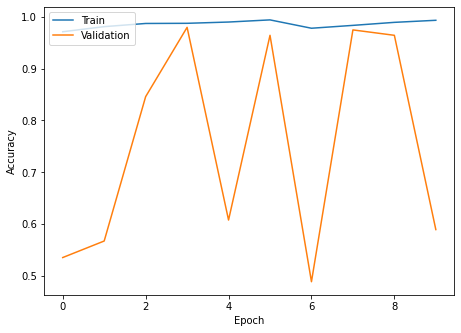

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

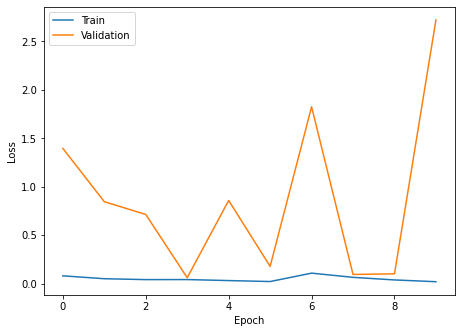

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

In [47]:
pred=model.predict(X_test)

In [50]:
pred_1=np.round(pred)

In [48]:
y_test

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [51]:
pred_1.shape

(2713, 1)

In [52]:
pred_1=pred_1.reshape((2713,))

In [53]:
pred_1

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
mat=confusion_matrix(y_test, pred_1)

In [59]:
print(mat)

[[1478   51]
 [   6 1178]]


In [58]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(y_test,pred_1))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1529
         1.0       0.96      0.99      0.98      1184

    accuracy                           0.98      2713
   macro avg       0.98      0.98      0.98      2713
weighted avg       0.98      0.98      0.98      2713

